**Get stock symbol agent**

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain langchain_openai tavily-python langgraph langchain_groq langchain_cohere

In [ ]:
from google.colab import userdata
import os

os.environ['COHERE_API_KEY'] = userdata.get('COHERE_KEY')
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_KEY')

In [ ]:
!pip install -Uq langchain_community langchainhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.9 MB/s eta 0:00:00


In [ ]:
!pip install -Uq langchain-google-genai

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

In [ ]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(temperature=0)

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

class Response(BaseModel):
  """Response from the model, list containing the symbols"""
  symbols: List[str] = Field(
      description="list of Stock symbols from output query"
  )

In [ ]:
os.environ['GOOGLE_API_KEY'] = userdata.get('GEMINI_API_KEY')

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
        """
        You are an AI agent that can identify company names, crypto currency names and forex names.\n
        You are give a task to identify them from a given sentence.
        output:
          - only the list containing the company names.
        example:
          input: What are the earnings of apple , tesla and roboc in 2024 Q1?
          output: [apple, tesla, roboc]

        NOTE: if none then output: [NONE]
        """),
        ('human', 'sentence: {messages}')
    ]
)

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

middle = ChatGoogleGenerativeAI(model='gemini-1.5-flash')

In [ ]:
middle_model = prompt | middle

In [ ]:
middle_model.invoke({"messages": "What are the financial statements of apple and tesla?"}).content

'[apple, tesla] \n'

In [ ]:
model = llm.bind_tools(tools + [Response])

In [ ]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [ ]:
def extractor(state):
    messages = state["messages"]
    response = middle_model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [ ]:
from langgraph.prebuilt import ToolInvocation
from langchain_core.messages import ToolMessage
from typing import Literal


# Define the function that determines whether to continue or not
def should_continue(state) -> Literal["continue", "end"]:
    messages = state["messages"]
    last_message = messages[-1]
    # Otherwise if there is, we need to check what type of function call it is
    if last_message.tool_calls[0]["name"] == "Response":
        return "end"

    return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    messages[-1].content = "what are the Stock market symbols for the companies mentioned in the following sentence use tavily_search_json tool, if not existing say none. finally use Response tool: " + messages[-1].content
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation for each tool call
    tool_invocations = []
    for tool_call in last_message.tool_calls:
        action = ToolInvocation(
            tool=tool_call["name"],
            tool_input=tool_call["args"],
        )
        tool_invocations.append(action)

    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    # We call the tool_executor and get back a response
    responses = tool_executor.batch(tool_invocations, return_exceptions=True)
    # We use the response to create tool messages
    tool_messages = [
        ToolMessage(
            content=str(response),
            name=tc["name"],
            tool_call_id=tc["id"],
        )
        for tc, response in zip(last_message.tool_calls, responses)
    ]

    # We return a list, because this will get added to the existing list
    return {"messages": tool_messages}

In [ ]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

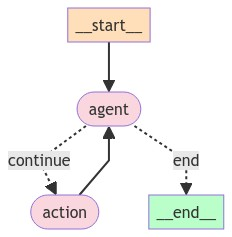

In [ ]:
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="Is it viable to sell singer srilanka stock and purchase softlogic PLC stocks")]}

In [ ]:
gr = app.invoke(inputs)

KeyboardInterrupt: 

In [ ]:
gr['messages'][-1].tool_calls[0]['args']['symbols']

In [ ]:
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool

In [ ]:
av_key = userdata.get('AV_KEY')

In [ ]:
import requests

@tool
def getIncomeStatements(query: str) -> str:
    """Get company income statement when symbol is provided"""

    # replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
    url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={query}&apikey={av_key}'
    r = requests.get(url)
    data = r.json()

    return data

In [ ]:
getIncomeStatements.name

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
        """
        You are an expert financial analyst in a team of analysts.\n
        You are given a task to analyse the income statements of a company.
        You are provided with the stock symbol and retrieved infomation from tools.
        output:
          - summary if income statement.
          - findings and conclusions reached.
          - pros & cons of investing in the company

        If you do not known say you don't know.
        """),
        ('human', 'stock symbol: {messages} \n\n retrieved information: {context}')
    ]
)

In [ ]:
model = prompt | middle

In [ ]:
model.invoke({'messages': "IBM", 'context': getIncomeStatements('IBM')})